# Normalization Analysis
---
Test whether a per-study normalization scheme leads to better model training than normalizing all studies simultaneously

In [1]:
import pandas
import plotnine
from plotnine import *

plotnine.options.figure_size = (8,6)

In [2]:
%%bash

python ../brdnet/normalize_expression_by_study.py ../data/classifier_healthy.tsv ../data/classifier_disease.tsv 2> /dev/null
python ../brdnet/normalize_expression_by_study.py ../data/plier_healthy.tsv ../data/plier_disease.tsv 2> /dev/null

In [3]:
%%bash
PLIER_OUT='../data/norm_plier'

mkdir -p $PLIER_OUT

K_VAL=50

Rscript ../brdnet/run_plier.R ../data/plier_healthy_normalized.tsv \
        ../data/plier_disease_normalized.tsv $PLIER_OUT \
        --noNorm -k $K_VAL 2> /dev/null
       
python ../brdnet/create_identity_matrix_df.py $PLIER_OUT/plier_${K_VAL}_Z.tsv $PLIER_OUT/plier_all_Z.tsv

[1] 142.1264
[1] "L2 is set to 142.126408570543"
[1] "L1 is set to 71.0632042852715"


In [4]:
%%bash
PLIER_OUT='../data/norm_plier'

python ../brdnet/evaluate_models.py $PLIER_OUT ../data/classifier_healthy_normalized.tsv \
                                    ../data/classifier_disease_normalized.tsv \
                                    --out_path ../results/norm_results.csv\
                                    --study_out_path ../results/study_norm_results.csv\
                                    --epochs 400 > /dev/null 2>&1

### Compare the accuracy of each model on ten different validation sets

In [5]:
# Load the dataframe generated by evaluate_models.py
result_df = pandas.read_csv('../results/norm_results.csv', index_col=0)

result_df['acc_over_baseline'] = result_df['val_acc'] - result_df['val_baseline']

result_df.head()

,Model,LR,Seed,val_acc,val_auroc,val_aupr,val_baseline,lv_count,acc_over_baseline
0,IForest,0.00001,0,0.629032,0.710718,0.681483,0.576029,6605,5.300364e-02
1,OCSVM,0.00001,0,0.645161,0.679501,0.666593,0.576029,6605,6.913267e-02
2,LogisticRegression,0.00001,0,0.606440,0.592054,0.561780,0.576029,6605,3.041144e-02
3,MLP,0.00001,0,0.576029,0.542089,0.473873,0.576029,6605,2.249835e-08
4,TenLayerNet,0.00001,0,0.575134,0.588984,0.529626,0.576029,6605,-8.944644e-04


/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


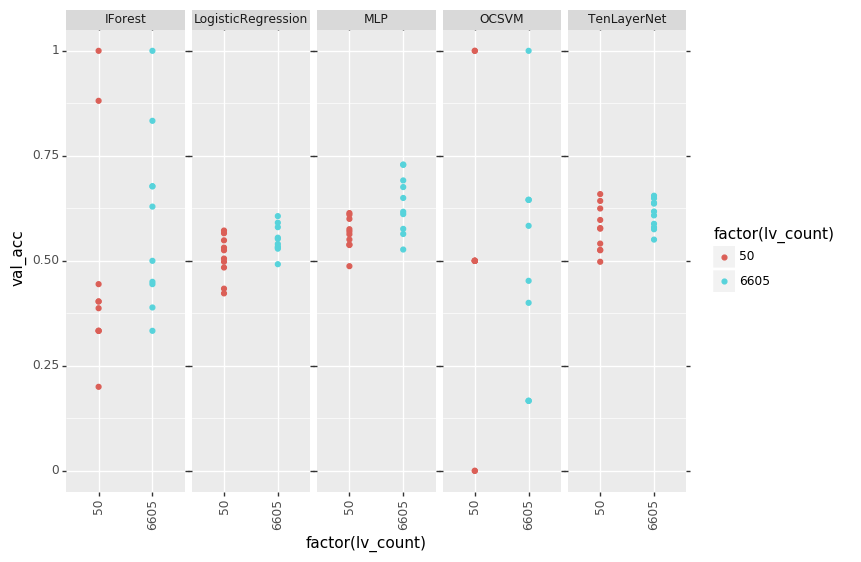

<ggplot: (8738774078991)>

In [6]:
ggplot(result_df, aes(x='factor(lv_count)', y='val_acc', color='factor(lv_count)')) +\
geom_point() +\
facet_grid('. ~ Model') +\
theme(axis_text_x=element_text(rotation=90, hjust=0.5))

### Plot adjusted accuracy
---
Since the accuracy measurements are based on different validation sets, it makes sense to compare them to a baseline model. In this case, the baseline predicts that every sample is from the larger class. The field `acc_over_baseline` is generated by subtracting the baseline model's accuracy from the main model.

/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/plotnine/utils.py:69: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(val) and not is_string(val):
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


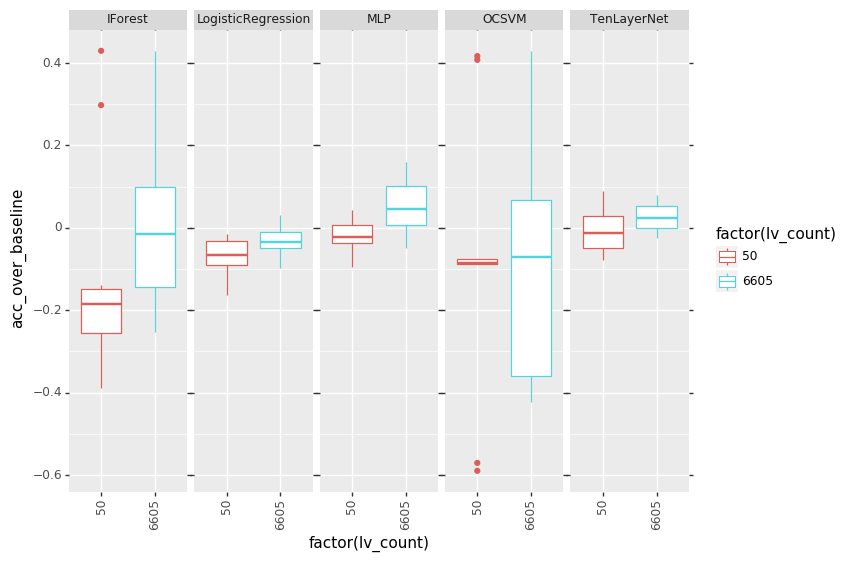

<ggplot: (8738773969279)>

In [7]:
ggplot(result_df, aes(x='factor(lv_count)', y='acc_over_baseline', color='factor(lv_count)')) +\
geom_boxplot() +\
facet_grid('. ~ Model') +\
theme(axis_text_x=element_text(rotation=90, hjust=0.5))

### Plot AUROC
---
The area under the receiver operating curve is a metric that evaluates a model across all score cutoffs instead of just one.

/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and s

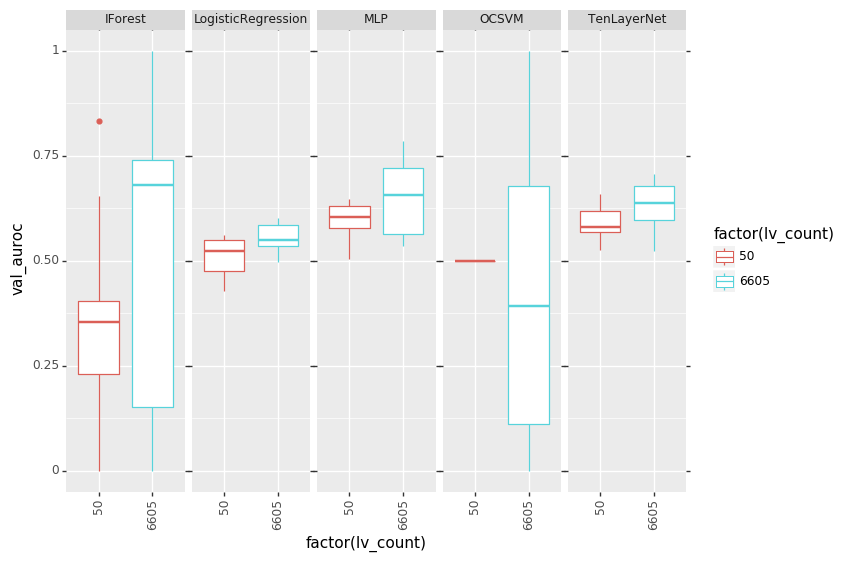

<ggplot: (-9223363298083792703)>

In [8]:
ggplot(result_df, aes(x='factor(lv_count)', y='val_auroc', color='factor(lv_count)')) +\
geom_boxplot() +\
facet_grid('. ~ Model') +\
theme(axis_text_x=element_text(rotation=90, hjust=0.5))

### Conclusions
At the global level, per-study normalization does not appear to imporve the performance of classifiers when compared to [row normalization](./compare_models.ipynb). It does appear to have a positive impact on outlier detection models though.

## Per-study analysis
Run some of the analyses performed in [per_study_analysis](./per_study_analysis.ipynb)

In [9]:
result_df = pandas.read_csv('../results/study_norm_results.csv', index_col=0)

result_df['acc_over_baseline'] = result_df['val_acc'] - result_df['val_baseline']

result_df.head()

,Model,Study,LR,Seed,val_acc,val_auroc,val_aupr,val_baseline,lv_count,acc_over_baseline
0,IForest,SRP003611,0.00001,0,0.0000,NaN,NaN,1.0000,6605,-1.0000
1,IForest,SRP055749,0.00001,0,0.5625,0.818182,0.731111,0.6875,6605,-0.1250
2,IForest,SRP029592,0.00001,0,0.2000,NaN,NaN,1.0000,6605,-0.8000
3,IForest,SRP043108,0.00001,0,0.8500,NaN,NaN,1.0000,6605,-0.1500
4,IForest,SRP020470,0.00001,0,0.5625,NaN,NaN,1.0000,6605,-0.4375


In [10]:
one_class_df = result_df[result_df['val_baseline'] == 1]
two_class_df = result_df[result_df['val_baseline'] != 1]

### Accuracy mean and std for all studies

In [11]:
for group, df in result_df.groupby(['Model']):
    print(group, df['val_acc'].mean())
print()
for group, df in result_df.groupby(['Model']):
    print(group, df['val_acc'].std())

IForest 0.5339952935317582
LogisticRegression 0.5669072528454391
MLP 0.5869522232020443
OCSVM 0.489394448421478
TenLayerNet 0.5806745158965615

IForest 0.3038815669998245
LogisticRegression 0.1843637917675085
MLP 0.2335013657299932
OCSVM 0.3651198797714138
TenLayerNet 0.2743832867230938


### Accuracy mean and std for studies with only one class
One class studies have either healthy samples or unhealthy samples, but not both.

In [12]:
for group, df in one_class_df.groupby(['Model']):
    print(group, df['val_acc'].mean())
print()
for group, df in one_class_df.groupby(['Model']):
    print(group, df['val_acc'].std())

IForest 0.5388929944443615
LogisticRegression 0.5456500488810423
MLP 0.5856028087891456
OCSVM 0.4663807309796113
TenLayerNet 0.597389571643548

IForest 0.3374476757711059
LogisticRegression 0.15956774467577745
MLP 0.24727569402460725
OCSVM 0.40476407707031
TenLayerNet 0.2913234935091394


### Accuracy mean and std for studies with two classes
This is the complement of the previous analysis, looking only at studies that have both healthy and unhealthy samples

In [13]:
for group, df in two_class_df.groupby(['Model']):
    print(group, df['val_acc'].mean())
print()
for group, df in two_class_df.groupby(['Model']):
    print(group, df['val_acc'].std())

IForest 0.5196520265734199
LogisticRegression 0.6291604930268867
MLP 0.5909040796969618
OCSVM 0.5567917637869445
TenLayerNet 0.531723281208958

IForest 0.1714309388979207
LogisticRegression 0.23257674512212453
MLP 0.188170240127434
OCSVM 0.19577192212860903
TenLayerNet 0.21069462442634607


### AUROC for two class studies

In [14]:
for group, df in two_class_df.groupby(['Model']):
    print(group, df['val_auroc'].mean())
print()
for group, df in two_class_df.groupby(['Model']):
    print(group, df['val_auroc'].std())

IForest 0.5493660929881268
LogisticRegression 0.6739330700997795
MLP 0.6675094704542841
OCSVM 0.5343578999792982
TenLayerNet 0.6226876952818462

IForest 0.25569005442216897
LogisticRegression 0.26179640869311344
MLP 0.21058402793827663
OCSVM 0.19368508469045717
TenLayerNet 0.23093598241713828


## Conclusions
Both the global and per-study analyses give comparable results when run on row normalized and per-study normalized data. The next step will be to train models on individual diseases to see whether a simpler dataset is more seperable.